# **Limpieza y Organización de Datos PS3**
<br>
Nicolas Lozano, Jhan Pulido, Gerardo Rendon, Samuel Narvaez
<br>
2025-05-06

## Limpiamos ambiente y cargamos paquetes

In [ ]:
rm(list = ls())

require(pacman)

p_load(
  "ggplot2",
  "tidyverse",
  "dplyr",
  "visdat"
)

# Set working directory to the project root
while (tail(strsplit(getwd(), "/")[[1]], 1) != "202510-MLBD-PS3") {
  setwd("..")
}

getwd()

options(
  repr.plot.width  = 10,   # inches  (default is 7)
  repr.plot.height = 6,    # inches  (default is 5)
  repr.plot.res    = 120   # DPI; larger → sharper but heavier files
)

[1] "c:/Users/NicolasLozano/OneDrive - Universidad de los andes/UNIVERSIDAD/9. NOVENO SEMESTRE/BIG DATA/ProblemSets/202510-MLBD-PS3"

## Cargue de datos

In [83]:
test <- read.csv(
  "stores\\test.csv"
)

train <- read.csv(
  "stores\\train.csv"
)

## Organizamos los datos

### Corregimos los tipos de variables

In [84]:
train <- train %>%
  mutate(
    year = as.factor(year),
    month = as.factor(month),
    property_type = as.factor(property_type),
    rooms = as.factor(rooms),
    bathrooms = as.factor(bathrooms),
    bedrooms = as.factor(bedrooms)
)

test <- test %>%
  mutate(
    year = as.factor(year),
    month = as.factor(month),
    property_type = as.factor(property_type),
    rooms = as.factor(rooms),
    bathrooms = as.factor(bathrooms),
    bedrooms = as.factor(bedrooms)
)

### Analizamos Missing Values

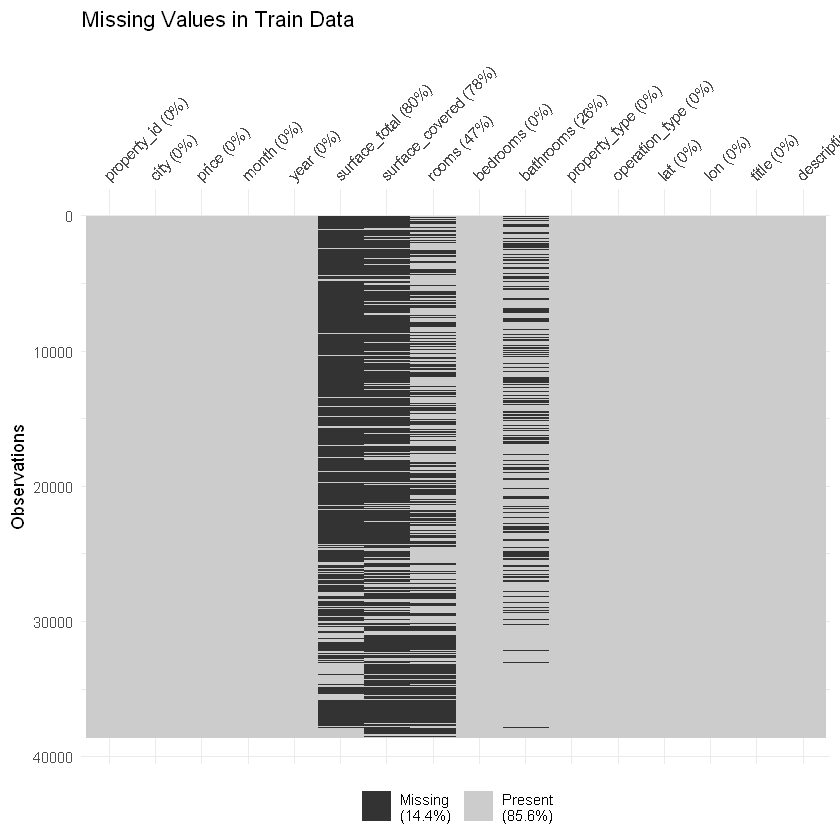

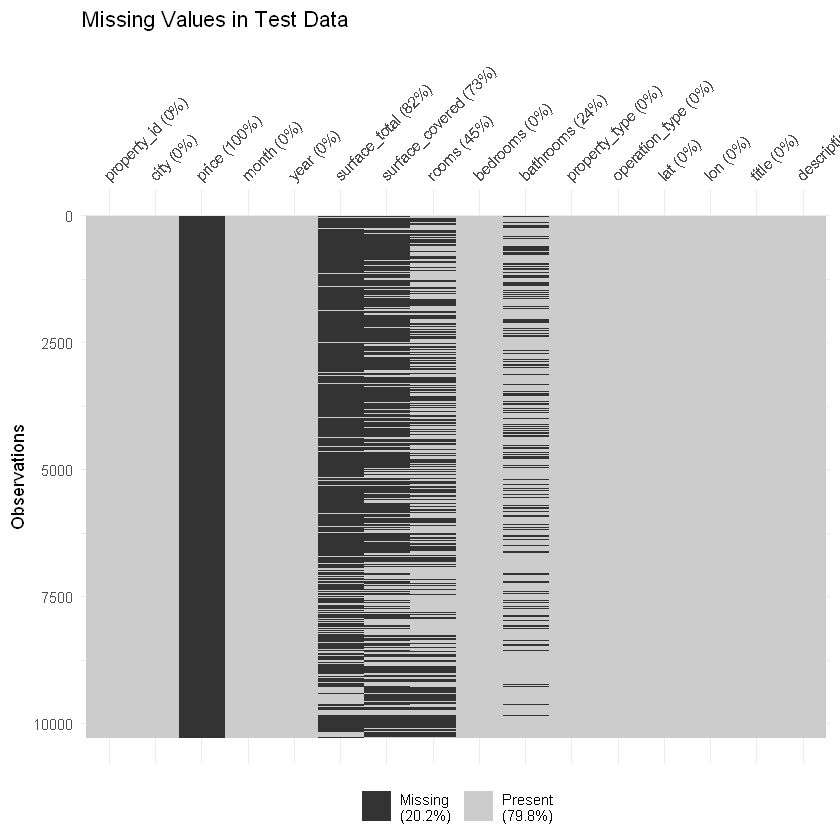

In [85]:
train  <- train %>%
            mutate(
              title = ifelse(is.na(title), "", title),
              description = ifelse(is.na(description), "", description)
            )

test  <- test %>%
            mutate(
              title = ifelse(is.na(title), "", title),
              description = ifelse(is.na(description), "", description)
            )

miss_train  <- vis_miss(train) +
            ggtitle("Missing Values in Train Data")

miss_test  <- vis_miss(test) +
            ggtitle("Missing Values in Test Data")

miss_train
miss_test

Hay un gran numero de missing values en la variables `surface_total`, `surface_covered`, `rooms` y `bathrooms`

### Imputamos valores para variables con gran número de missing values

Para habitaciones y baños usamos la moda al ser variables discretas

In [86]:
train  <- train %>% 
    mutate(
        rooms = ifelse(is.na(rooms) == T, as.numeric(names(sort(table(rooms))[1])), rooms),
        bathrooms = ifelse(is.na(bathrooms) == T, as.numeric(names(sort(table(bathrooms))[1])), bathrooms),
    )

test  <- test %>% 
    mutate(
        rooms = ifelse(is.na(rooms) == T, as.numeric(names(sort(table(rooms))[1])), rooms),
        bathrooms = ifelse(is.na(bathrooms) == T, as.numeric(names(sort(table(bathrooms))[1])), bathrooms),
    )

In [87]:
train <- train %>%
  mutate(
    rooms = as.integer(as.character(rooms)),
    bathrooms = as.integer(as.character(bathrooms)),
    bedrooms = as.integer(as.character(bedrooms))
)

test <- test %>%
  mutate(
    rooms = as.integer(as.character(rooms)),
    bathrooms = as.integer(as.character(bathrooms)),
    bedrooms = as.integer(as.character(bedrooms))
)

Al imputar utilizando la moda, especialmente para el caso de la variable `rooms` donde el procentaje de valores faltantes esta entre 45% y 47%, se podría estar sesgando la distribución. Se sugiere a futuro escoger otros métodos de imputación que no introduzcan este problema.

Para las variables de superficies al ser variables continuas imputamos utilizando la mediana y un método de regresión.

In [88]:
train  <- train  %>% 
            mutate(
                surface_covered_reg = surface_covered,
                surface_total_reg = surface_total,
            )

test  <- test  %>% 
            mutate(
                surface_covered_reg = surface_covered,
                surface_total_reg = surface_total,
            )

Imputación con la mediana

In [89]:
train  <- train  %>% 
            mutate(
                surface_covered = ifelse(is.na(surface_covered) == T, median(surface_covered, na.rm = T), surface_covered),
                surface_total = ifelse(is.na(surface_total) == T, median(surface_total, na.rm = T), surface_total),
            )

test  <- test  %>% 
            mutate(
                surface_covered = ifelse(is.na(surface_covered) == T, median(surface_covered, na.rm = T), surface_covered),
                surface_total = ifelse(is.na(surface_total) == T, median(surface_total, na.rm = T), surface_total),
            )

Imputación con regresión

In [90]:
linear_imput_model_covered  <- lm(
    surface_covered_reg ~ 
        property_type + rooms + bathrooms + bedrooms,
    data = train, na.action = na.exclude
)   

linear_imput_model_total  <- lm(
    surface_total_reg ~ 
        property_type + rooms + bathrooms + bedrooms,
    data = train, na.action = na.exclude
)

train$pred_total  <- predict(
    linear_imput_model_total,
    newdata = train
)

train$pred_covered  <- predict(
    linear_imput_model_covered,
    newdata = train
)

linear_imput_model_covered  <- lm(
    surface_covered_reg ~ 
        property_type + rooms + bathrooms + bedrooms,
    data = test, na.action = na.exclude
)   

linear_imput_model_total  <- lm(
    surface_total_reg ~ 
        property_type + rooms + bathrooms + bedrooms,
    data = test, na.action = na.exclude
)

test$pred_covered  <- predict(
    linear_imput_model_covered,
    newdata = test
)

test$pred_total  <- predict(
    linear_imput_model_total,
    newdata = test
)

train  <- train  %>% 
            mutate(
                surface_covered_reg = ifelse(is.na(surface_covered_reg) == T, pred_covered, surface_covered_reg),
                surface_total_reg = ifelse(is.na(surface_total_reg) == T, pred_total, surface_total_reg)
            )

test  <- test  %>% 
            mutate(
                surface_covered_reg = ifelse(is.na(surface_covered_reg) == T, pred_covered, surface_covered_reg),
                surface_total_reg = ifelse(is.na(surface_total_reg) == T, pred_total, surface_total_reg)
            )


Warning message in predict.lm(linear_imput_model_covered, newdata = test):
"prediction from rank-deficient fit; attr(*, "non-estim") has doubtful cases"


Dejar las variables `rooms`, `bathrooms` y `bedrooms` como factores arroja error, debido al gran número de missing values en las variables dependientes. Por esto se dejan como enteros. Ahora miramos las distribuciones para las variables imputadas.

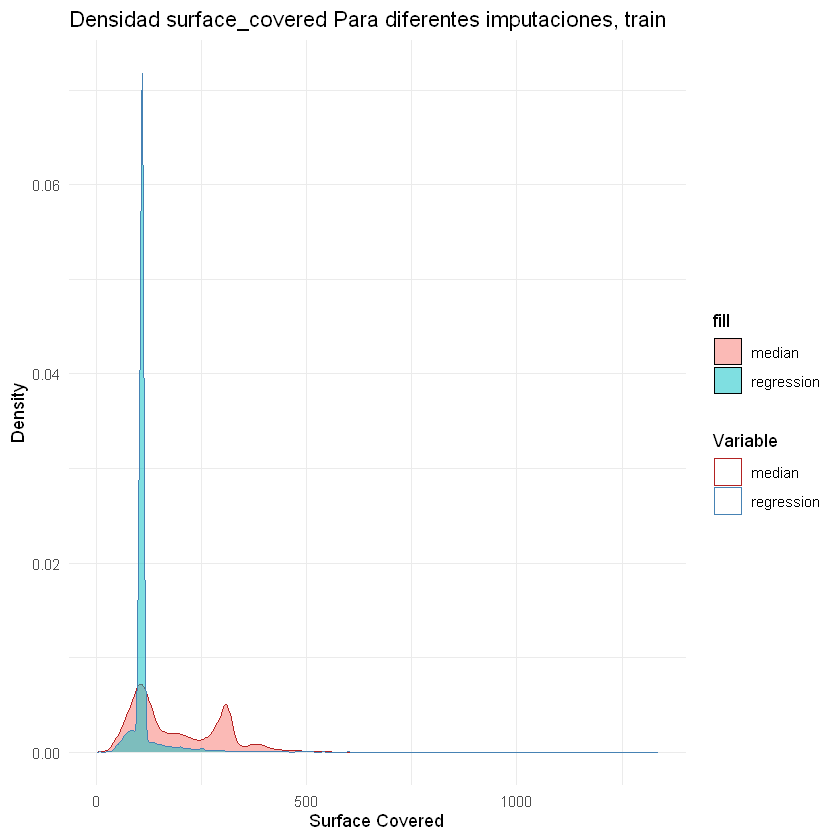

In [ ]:
ggplot() +
    geom_density(
        data = train,
        aes(
            x = surface_covered_reg,
            colour = "regression",
            fill = "regression"
        ),
        alpha = 0.5
    ) +
    geom_density(
        data = train,
        aes(
            x = surface_covered,
            colour = "median",
            fill = "median"
        ),
        alpha = 0.5
    ) +
    scale_colour_manual(
        name   = "Variable",                     # legend title
        values = c(regression = "steelblue",
                median = "firebrick")
    ) +
    labs(
        title = "Densidad surface_covered Para diferentes imputaciones, train",
        x = "Surface Covered",
        y = "Density"
    ) +
    theme_minimal() 

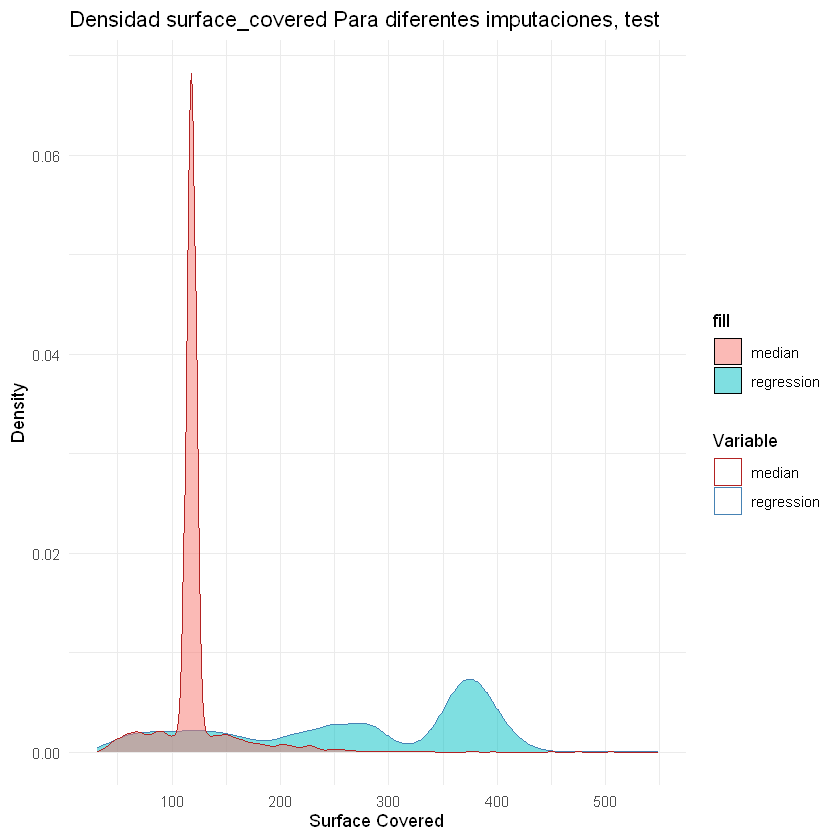

In [96]:
ggplot() +
    geom_density(
        data = test,
        aes(
            x = surface_covered_reg,
            colour = "regression",
            fill = "regression"
        ),
        alpha = 0.5
    ) +
    geom_density(
        data = test,
        aes(
            x = surface_covered,
            colour = "median",
            fill = "median"
        ),
        alpha = 0.5
    ) +
    scale_colour_manual(
        name   = "Variable",
        values = c(regression = "steelblue",
                median = "firebrick")
    ) +
    labs(
        title = "Densidad surface_covered Para diferentes imputaciones, test",
        x = "Surface Covered",
        y = "Density"
    ) +
    theme_minimal() 

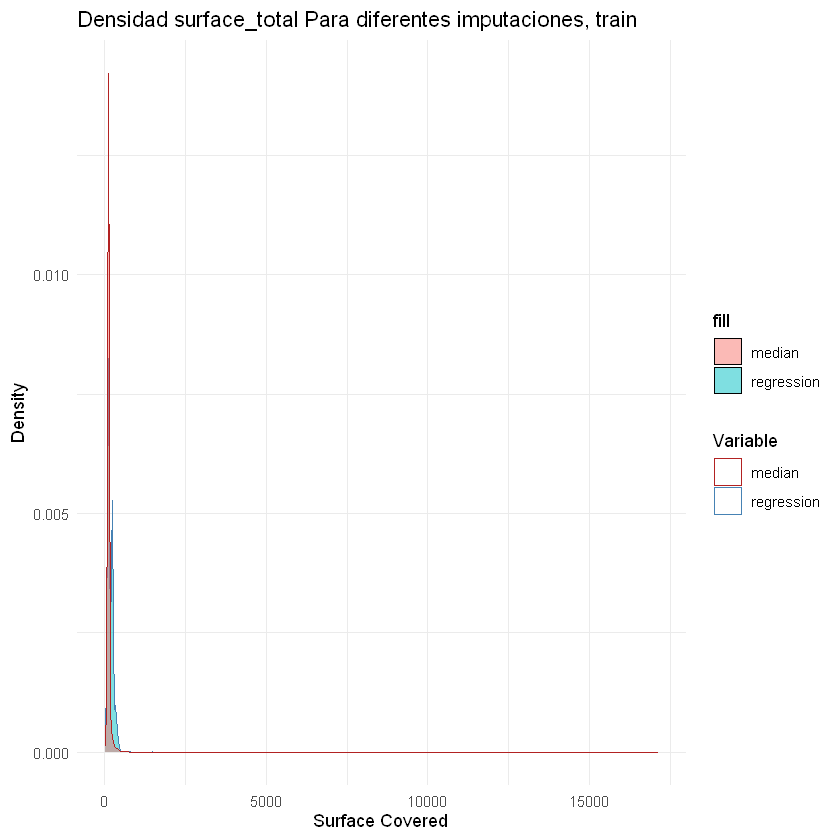

In [97]:
ggplot() +
    geom_density(
        data = train,
        aes(
            x = surface_total_reg,
            colour = "regression",
            fill = "regression"
        ),
        alpha = 0.5
    ) +
    geom_density(
        data = train,
        aes(
            x = surface_total,
            colour = "median",
            fill = "median"
        ),
        alpha = 0.5
    ) +
    scale_colour_manual(
        name   = "Variable",
        values = c(regression = "steelblue",
                median = "firebrick")
    ) +
    labs(
        title = "Densidad surface_total Para diferentes imputaciones, train",
        x = "Surface Covered",
        y = "Density"
    ) +
    theme_minimal() 

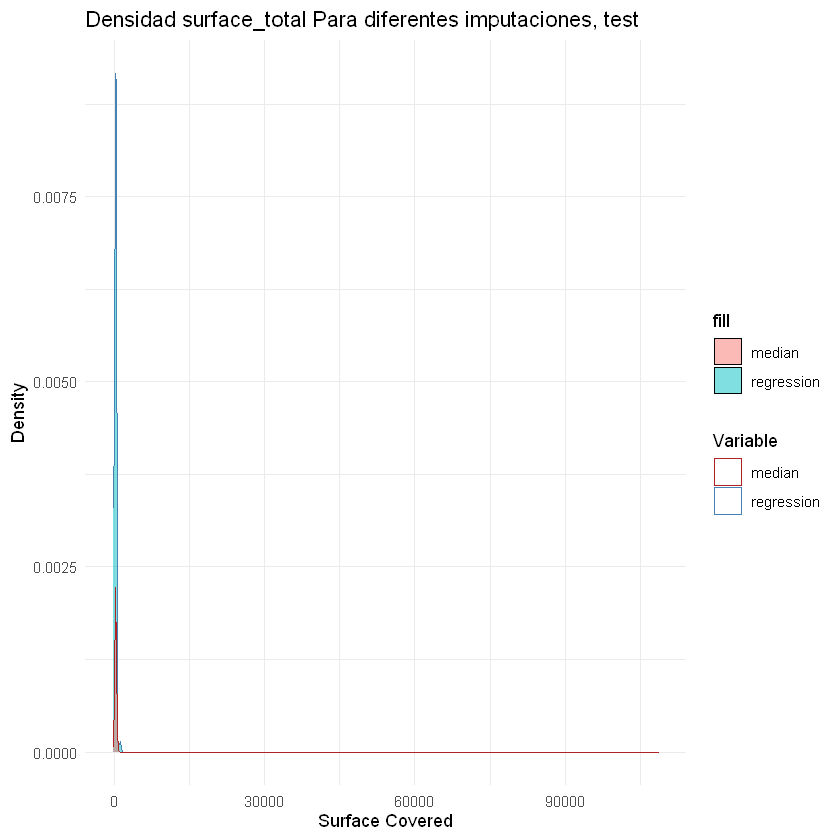

In [98]:
ggplot() +
    geom_density(
        data = test,
        aes(
            x = surface_total_reg,
            colour = "regression",
            fill = "regression"
        ),
        alpha = 0.5
    ) +
    geom_density(
        data = test,
        aes(
            x = surface_total,
            colour = "median",
            fill = "median"
        ),
        alpha = 0.5
    ) +
    scale_colour_manual(
        name   = "Variable",
        values = c(regression = "steelblue",
                median = "firebrick")
    ) +
    labs(
        title = "Densidad surface_total Para diferentes imputaciones, test",
        x = "Surface Covered",
        y = "Density"
    ) +
    theme_minimal() 